## EDA
In interations, too. Can't know it all at a first glance.

In [1]:
# Kaggle version check
# import torch
# print(torch.__version__) # 2.5.1+cu121
# print(torch.version.cuda)  # Check CUDA version (if using GPU) # 12.1


2.5.1+cu121
12.1


In [1]:
import os
import glob

import pandas as pd

# Image processing
import tifffile
import matplotlib.pyplot as plt


In [7]:
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

DATA_ROOT_PATH = "data"
IMAGE_DIRECTORY_PATH = os.path.join(DATA_ROOT_PATH, "images")
IMAGE_DIRS = sorted(glob.glob(os.path.join(IMAGE_DIRECTORY_PATH, "*.tif")))
print(len(IMAGE_DIRS))
print(IMAGE_DIRS[:5])

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml
200
['data/images/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif', 'data/images/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.tif', 'data/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif', 'data/images/IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C.tif', 'data/images/IXMtest_A15_s5_w1825174D4-ED30-490C-9635-6196417D6C9D.tif']


### Questions
* Data quality, distribution, outliers?
* Image: histogram

#### Image metadata
* size (uniform: 520*696)
* resolution (NA: Can't get physical resolution from tif header? Calculation result not sensible: X resolution: 352.78 µm, Y resolution: 352.78 µm
* tif stack(1 - no stack)

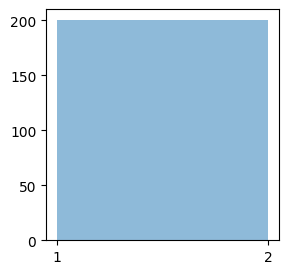

In [9]:
# Z stack
num_z = []
for file_path in IMAGE_DIRS:

    # Open the TIFF file and extract the width and height of each page
    with tifffile.TiffFile(file_path) as tiff:
        num_z.append(len(tiff.pages))

# Create a scatter plot
plt.figure(figsize=(3, 3))
plt.hist(num_z, bins=range(1, max(num_z) + 2), alpha=0.5)
plt.xticks(range(1, max(num_z) + 2))
plt.show()

In [14]:
with tifffile.TiffFile(IMAGE_DIRS[5]) as tiff:
    for i, page in enumerate(tiff.pages):
        # print(page.tags)
        w, h = page.shape[:2]

        # Can't get physical resolution from tif header?
        # Calculation result not sensible: X resolution: 352.78 µm, Y resolution: 352.78 µm
        # x_res = page.tags['XResolution'].value[1] / page.tags['XResolution'].value[0] * 25400  # Convert to micrometers per pixel
        # y_res = page.tags['YResolution'].value[1] / page.tags['YResolution'].value[0] * 25400
        # print(f"Width: {w}, Height: {h}, X resolution: {x_res:.2f} µm, Y resolution: {y_res:.2f} µm")

        break

Width: 520, Height: 696, X resolution: 352.78 µm, Y resolution: 352.78 µm


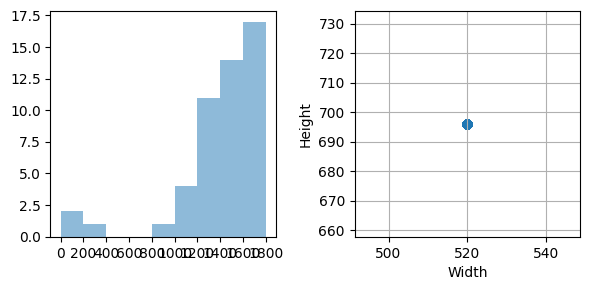

In [36]:
# Lists to store the width and height of each page
widths = []
heights = []
max_values = []

for file_path in IMAGE_DIRS:
    # Open the TIFF file and extract the width and height of each page
    with tifffile.TiffFile(file_path) as tiff:
        w, h = tiff.pages[0].shape[:2]
        widths.append(w)
        heights.append(h)
        max_value = tiff.pages[0].asarray().flatten().max()
        max_values.append(max_value)

# Create scatter plot
figs, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].hist(max_values, bins=range(0, 2000, 200), alpha=0.5)
axes[0].set_xticks(range(0, 2000, 200))
axes[1].scatter(widths, heights, alpha=0.5)
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Pack the image information into a DataFrame
df_image_info = pd.DataFrame(
    {
        "file_path": IMAGE_DIRS,
        "max_value": max_values,
        "num_z": num_z,
        "width": widths,
        "height": heights
    }
)
df_image_info["mask_path"] = df_image_info["file_path"].str.replace("images", "masks").str.replace(".tif", ".png")

df_image_info[df_image_info["max_value"] < 500]

,file_path,max_value,num_z,width,height,mask_path
68,data/images/IXMtest_F13_s7_w13C1B1D8C-293E-454...,208,1,520,696,data/masks/IXMtest_F13_s7_w13C1B1D8C-293E-454F...
138,data/images/IXMtest_L01_s2_w1E5038251-DBA3-44D...,170,1,520,696,data/masks/IXMtest_L01_s2_w1E5038251-DBA3-44D0...
145,data/images/IXMtest_L10_s6_w12D12D64C-2639-4CA...,185,1,520,696,data/masks/IXMtest_L10_s6_w12D12D64C-2639-4CA8...


#### Image viewer
* Outliers: background with no cells

In [89]:
def view_image(df_image_info):
    for row in df_image_info.itertuples():

        im = plt.imread(row.file_path)
        mask = plt.imread(row.mask_path)

        figs, axes = plt.subplots(1, 4, figsize=(15, 3))
        figs.colorbar(axes[0].imshow(im, cmap="gray"), ax=axes[0])
        axes[0].set_title("Original Image")

        axes[1].hist(im.ravel(), bins=20, alpha=0.5)
        axes[1].set_title("Image Histogram")

        figs.colorbar(axes[2].imshow(mask[:,:,0]), ax=axes[2])
        axes[2].set_title("Mask")

        axes[3].hist(mask[:,:,0].ravel(), bins=20, alpha=0.5)

        plt.tight_layout()
        plt.show()
    return

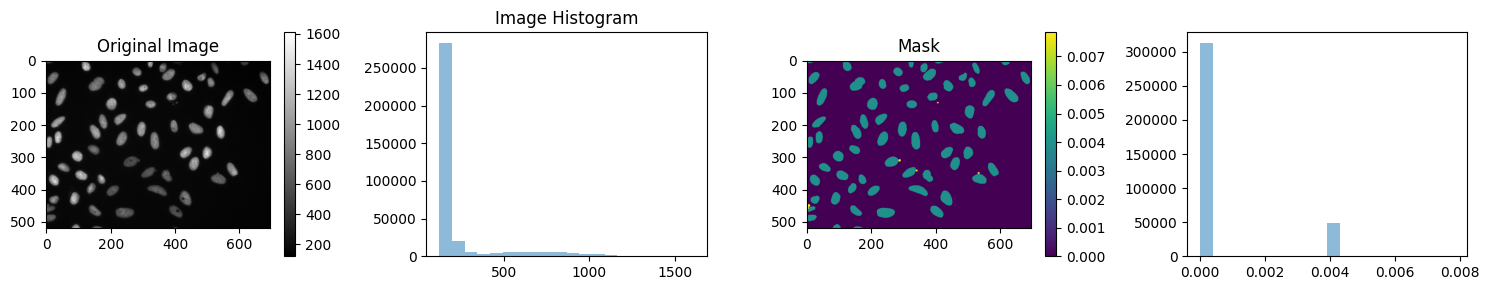

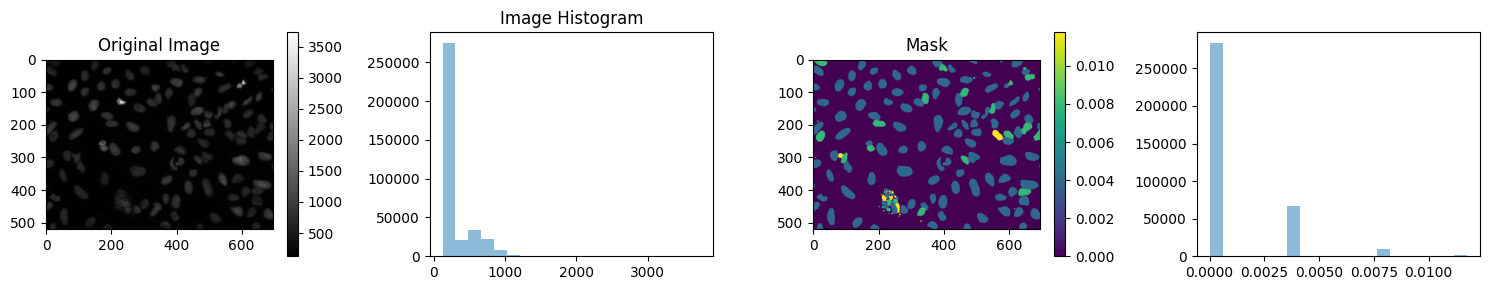

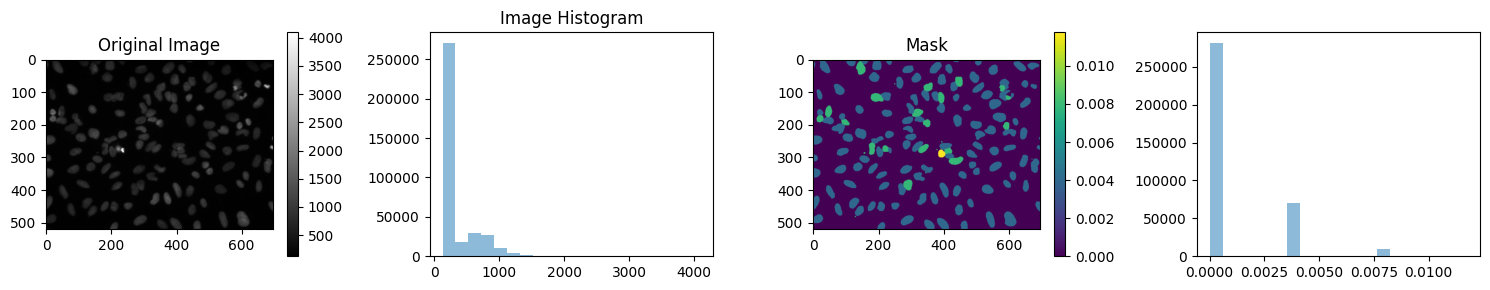

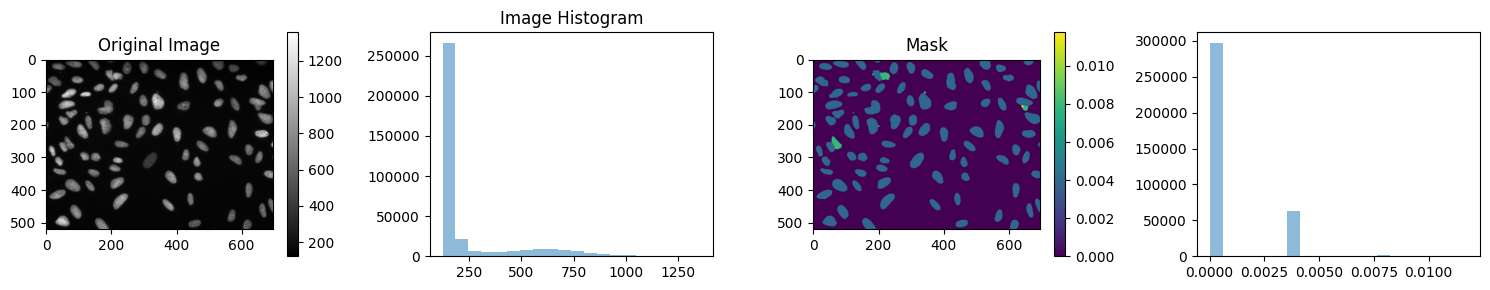

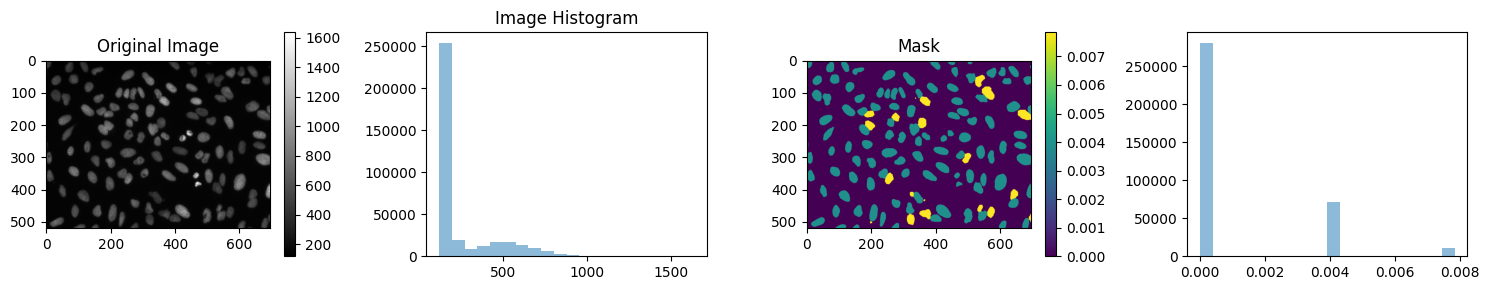

In [90]:
# Random 5 images to view
view_image(df_image_info.sample(5))

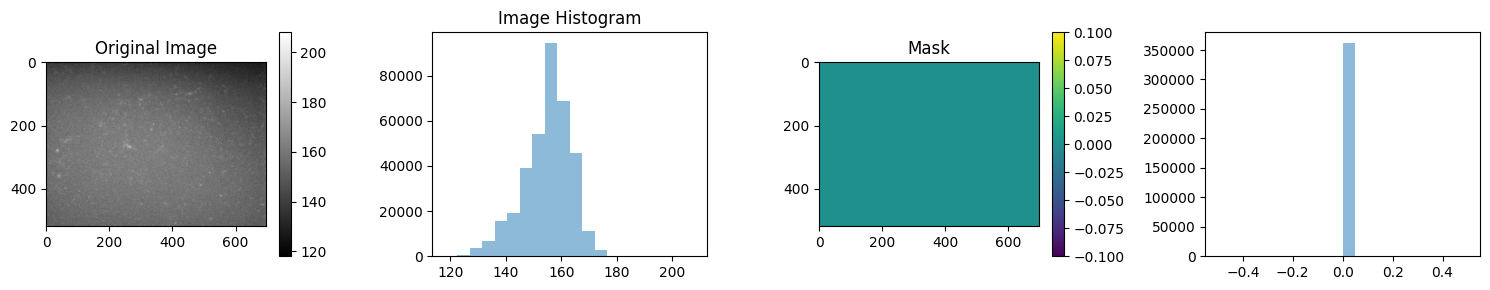

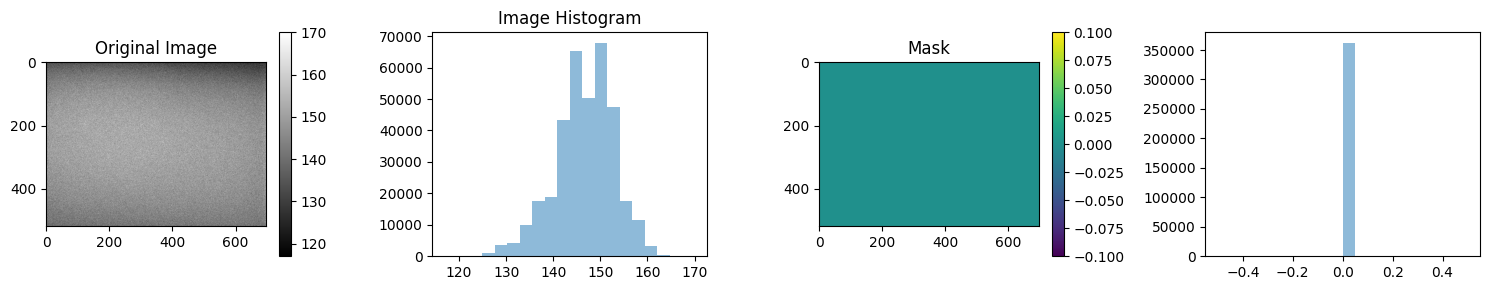

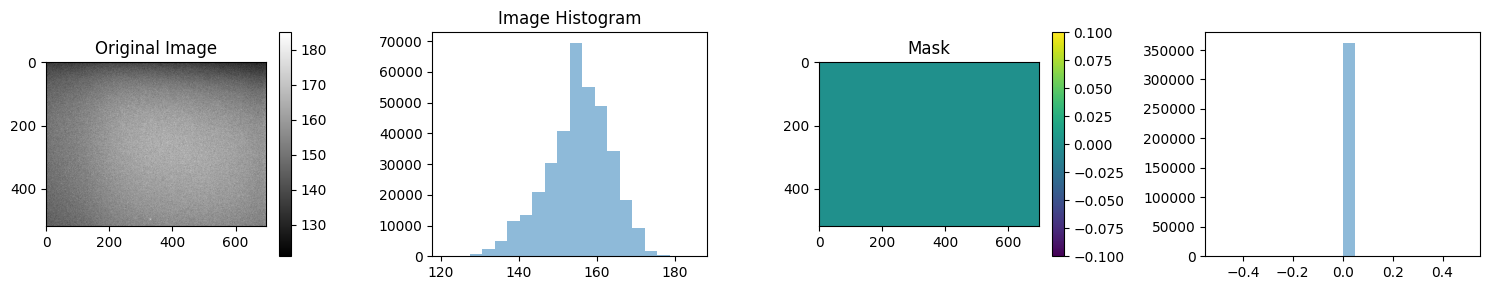

In [91]:
# Background only with no cells
view_image(df_image_info[df_image_info["max_value"] < 500])